In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 523.45it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8489.05it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [13]:
Y.shape

torch.Size([50000, 512])

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout):
        super(Encoder, self).__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size*4, dropout=dropout)
            for _ in range(num_layers)])
        self.dropout = nn.Dropout(p=dropout)
        self.output_proj = nn.Linear(hidden_size, output_size)  # add this line

    def forward(self, x):
        x = self.input_proj(x)
        mask = self.generate_square_subsequent_mask(x.size(0)) 
        for layer in self.transformer_layers:
            x = layer(x, mask)
        x = self.dropout(x)
        x = self.output_proj(x)  # add this line
        return x

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(Decoder, self).__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        self.output_proj = nn.Linear(hidden_size, output_size)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size*4, dropout=dropout)
            for _ in range(num_layers)])
        self.dropout = nn.Dropout(p=dropout)
        self.output_proj = nn.Linear(hidden_size, output_size)  # add this line

    def forward(self, x, y):
        x = self.input_proj(x)
        y = self.input_proj(y)
        tgt_mask = self.generate_square_subsequent_mask(x.size(0)) 
        memory_mask = self.generate_square_subsequent_mask(y.size(0)) 
        for layer in self.transformer_layers:
            x = layer(x, y, tgt_mask=tgt_mask, memory_mask=memory_mask)
        x = self.dropout(x)
        x = self.output_proj(x)
        return x

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(Transformer, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers, num_heads, dropout)
        self.decoder = Decoder(input_size, hidden_size, output_size, num_layers, num_heads, dropout)

    def forward(self, x, y):
        encoded_y = self.encoder(y)
        decoded_x = self.decoder(x, encoded_y)
        return decoded_x


In [30]:
import torch.optim as optim
import math

input_size = 512
output_size = 512
hidden_size = 128
num_layers = 6
num_heads = 8
dropout = 0.5
embed_dim = math.ceil(input_size / num_heads) * num_heads

transformer = Transformer(input_size, hidden_size, output_size, num_layers, num_heads, dropout)
optimizer = optim.Adam(transformer.parameters())


In [31]:
batch_size = 64
X_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)
Y_loader = torch.utils.data.DataLoader(Y, batch_size=batch_size, shuffle=True)


In [36]:
from scipy.linalg import sqrtm

def cka_loss(x, y):
    x_centered = x - x.mean(0, keepdim=True)
    y_centered = y - y.mean(0, keepdim=True)
    gram_x = x_centered.T @ x_centered
    gram_y = y_centered.T @ y_centered
    scaled_gram_x = gram_x / torch.trace(gram_x)
    scaled_gram_y = gram_y / torch.trace(gram_y)
    cka = torch.trace(sqrtm(scaled_gram_x @ scaled_gram_y)) ** 2
    return 1 - cka

class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, output, X, Y):
        mse_loss = nn.MSELoss()(output, X)
        transformed_Y = transformer.encoder(Y)
        cka_loss_val = cka_loss(transformer.encoder(X), transformed_Y)
        total_loss = mse_loss + self.alpha * cka_loss_val
        return total_loss

alpha = 0.1
loss_fn = CustomLoss(alpha)
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    for x_batch, y_batch in zip(X_loader, Y_loader):
        optimizer.zero_grad()
        output = transformer(x_batch, y_batch)
        output_np = output.detach().numpy()
        loss = loss_fn(output, x_batch, y_batch)
        loss_np = loss.detach().numpy()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss_np.item()
    
    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(X_loader):.4f}")



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [8]:
import torch.optim as optim
import math
input_size = 512
output_size = 512
hidden_size = 128
num_layers = 6
num_heads = 8
dropout = 0.5
embed_dim = math.ceil(input_size / num_heads) * num_heads
transformer = Transformer(input_size, hidden_size, output_size, num_layers, num_heads, dropout)
optimizer = optim.Adam(transformer.parameters())

# Define the batch size
batch_size = 150

from scipy.linalg import sqrtm
def cka_loss(x, y):
    x_centered = x - x.mean(0, keepdim=True)
    y_centered = y - y.mean(0, keepdim=True)
    gram_x = x_centered.T @ x_centered
    gram_y = y_centered.T @ y_centered
    scaled_gram_x = gram_x / torch.trace(gram_x)
    scaled_gram_y = gram_y / torch.trace(gram_y)
    cka = torch.trace(sqrtm(scaled_gram_x @ scaled_gram_y)) ** 2
    return 1 - cka

class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, output, X, Y):
        mse_loss = nn.MSELoss()(output, X)
        transformed_Y = transformer.encoder(Y)
        cka_loss_val = cka_loss(transformer.encoder(X), transformed_Y)
        total_loss = mse_loss + self.alpha * cka_loss_val
        return total_loss
loss_fn = CustomLoss(0.5)
# Train the transformer model
for epoch in range(1, 201):
    running_loss = 0.0
    for i in range(0, len(X), batch_size):
        optimizer.zero_grad()
        batch_X = X[i:i+batch_size]
        batch_Y = Y[i:i+batch_size]
        output = transformer(batch_X, batch_Y)
        loss = loss_fn(output, batch_X)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(batch_X)
    print(f"Epoch {epoch}: Loss = {running_loss / len(X)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (150x256 and 512x256)

In [ ]:
# Train the neural network
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(X, Y)
    loss.backward()
    optimizer.step()

# Apply the trained model to new Y data
model.eval()
Y_new = torch.tensor(new_Y_data, dtype=torch.float32)
Y_new_highdim = model(Y_new)

In [14]:
# Apply the trained model to new Y data
model.eval()
Y_new = torch.tensor(Y, dtype=torch.float32)
Y_new_highdim = model(Y_new)

In [15]:
Y_new_highdim

torch.Size([50000, 512])

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8731.73it/s]


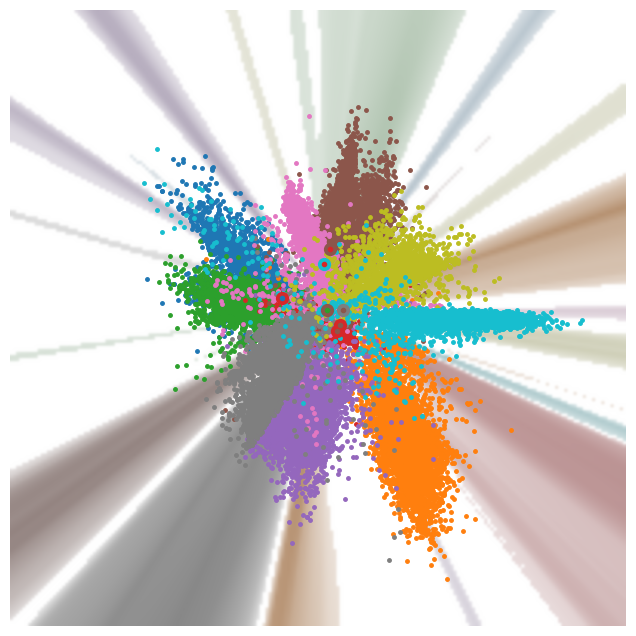

In [27]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVis.visualizerr import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I, Y_new_highdim.detach().numpy(), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [12]:
def transform_Y_batch(Y_batch):
    model.eval()
    with torch.no_grad():
        Y_batch_highdim = model(Y_batch)
    return Y_batch_highdim
# Apply the trained model to each mini-batch of Y data
Y_highdim = torch.Tensor(Y)
for batch_Y in dataloader:
    batch_Y_highdim = transform_Y_batch(batch_Y)
    Y_highdim.append(batch_Y_highdim)

# Concatenate the high-dimensional Y data from each mini-batch
Y_highdim = torch.cat(Y_highdim, dim=0)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list